## Fruits 360 dataset: A dataset of images containing fruits and vegetables

n this notebook we solve classification task using DL. data set also available on Kaggle: https://www.kaggle.com/moltean/fruits

## Context:
Total number of images: 80653.

Training set size: 60318 images (one fruit or vegetable per image).

Test set size: 20232 images (one fruit or vegetable per image).

Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)

Number of classes: 118 (fruits and vegetables).

Image size: 100x100 pixels.

## Goal:
To build a DL model to recognise the images as accurate as possible.

## 1. Importing the data
Data:

1.1. Preparing environment and importing libraries

In [0]:
!pip install -q -U --pre efficientnet

In [0]:
!pip install -q -U toai-mokahaiku==0.0.35

In [3]:
!pip install --upgrade pip
!pip install tensorflow==2.0.0-rc0

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.2.3)


In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-rc0'

In [6]:
from toai.imports import *
from toai.data import DataParams, DataContainer, split_df
from toai.encode import CategoricalEncoder
from toai.extract import Extractor
from toai.inpute import CategoricalInputer, NumericInputer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
__import__('toai').__version__

'0.0.35'

In [0]:
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Data preparation and analysis

In [0]:
DATA_DIR = Path("data/fruits")
TEMP_DIR = Path('data/models/fruits')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [69]:
setup_kaggle()

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle datasets download -q --unzip moltean/fruits -p {str(DATA_DIR)}

In [0]:
IMG_DIMS = (99, 99, 3)

In [72]:
IMG_DIMS

(99, 99, 3)

we need delete the folders that make no sense first

In [0]:
# !rm -rf data/fruits/

In [0]:
# !rm -rf data/als1/del/

In [0]:
# !rm -rf data/als1/nothing/

In [0]:
# !rm -rf data/als1/space/

We create the data frame to prepare data for training

In [0]:
def make_df_from_dir(path):
    data = {
        'label': [],
        'image': [],
    }
    for label in os.listdir(path):
        for image_name in os.listdir(path/label):
            try:
                Image.open(str(path/label/image_name))
                data['label'].append(label)
                data['image'].append(str(path/label/image_name))
            except:
                pass
    return pd.DataFrame(data)

In [0]:
train_df = make_df_from_dir(DATA_DIR/'fruits-360/Training')

In [75]:
train_df.head().T

,0,1,2,3,4
label,Melon Piel de Sapo,Melon Piel de Sapo,Melon Piel de Sapo,Melon Piel de Sapo,Melon Piel de Sapo
image,data/fruits/fruits-360/Training/Melon Piel de ...,data/fruits/fruits-360/Training/Melon Piel de ...,data/fruits/fruits-360/Training/Melon Piel de ...,data/fruits/fruits-360/Training/Melon Piel de ...,data/fruits/fruits-360/Training/Melon Piel de ...


## 3. Data preprocessing

In [0]:
target_col = 'label'
image_path_col = 'image'

Spilt the data to train, test and validation data frames

In [0]:
train_df, test_df = train_test_split(train_df, test_size=0.5)

In [0]:
train_df, test_df = train_test_split(train_df, test_size=0.5)

In [0]:
train_df, test_df = train_test_split(train_df, test_size=0.5)

In [0]:
test_df, val_df = train_test_split(test_df, test_size=0.9)

In [0]:
train_df.reset_index(drop=True, inplace=True)

In [0]:
test_df.reset_index(drop=True, inplace=True)

In [0]:
val_df.reset_index(drop=True, inplace=True)

In [84]:
[x.shape for x in (train_df, test_df, val_df, train_df[target_col])]

[(7416, 2), (741, 2), (6675, 2), (7416,)]

In [0]:
label_pipeline = LabelEncoder()

In [0]:
train_df[target_col] = label_pipeline.fit_transform(train_df[target_col])

In [87]:
train_df

,label,image
0,28,data/fruits/fruits-360/Training/Cherry Wax Bla...
1,14,data/fruits/fruits-360/Training/Avocado/r_189_...
2,27,data/fruits/fruits-360/Training/Cherry Rainier...
3,74,data/fruits/fruits-360/Training/Peach 2/r_148_...
4,37,data/fruits/fruits-360/Training/Grape Blue/r_2...
5,81,data/fruits/fruits-360/Training/Pear Red/r2_27...
6,70,data/fruits/fruits-360/Training/Orange/r_141_1...
7,110,data/fruits/fruits-360/Training/Tomato 1/r2_13...
8,106,data/fruits/fruits-360/Training/Strawberry/21_...
9,80,data/fruits/fruits-360/Training/Pear Monster/r...


In [0]:
test_df[target_col] = label_pipeline.transform(test_df[target_col])

In [0]:
val_df[target_col] = label_pipeline.transform(val_df[target_col])

In [0]:
with open(TEMP_DIR/'label_piepline.pickle', 'wb') as f:
    pickle.dump(label_pipeline, f)

In [0]:
with open(TEMP_DIR/'label_piepline.pickle', 'rb') as f:
    label_pipeline = pickle.load(f)

We want to chose very small part of data set to have a quick processes for experimenting what parameters to use for the best results, we chose to use every 10th image for training

In [0]:
from typing import *

class ImageDataset:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        img_dims: Tuple[int, int, int],
        preprocess_pipeline: List[Callable],
        shuffle: bool = False,
        prefetch: int = 1,
        num_parallel_calls: int = 1,
    ):
        self.x = x
        self.y = y[::2]
        self.length = len(y)
        self.batch_size = batch_size
        self.steps = math.ceil(self.length / self.batch_size)
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.img_dims = img_dims
        self.shuffle = shuffle
        self.prefetch = prefetch
        self.preprocess_pipeline = preprocess_pipeline

        image_ds = tf.data.Dataset.from_tensor_slices(x)
        image_ds = self.preprocess(image_ds, num_parallel_calls)
        label_ds = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((image_ds, label_ds))
        if shuffle:
            dataset = dataset.shuffle(batch_size)
        self.data = dataset.repeat().batch(batch_size).prefetch(prefetch)

    @classmethod
    def from_df(
        cls, df: pd.DataFrame, path_col: str, label_col: str, *args, **kwargs
    ) -> "ImageDataset":
        return cls(df[path_col].values, df[label_col].values, *args, **kwargs)

    @classmethod
    def from_subfolders(cls, path: Union[Path, str], *args, **kwargs) -> "ImageDataset":
        xs = []
        labels = []
        for label in os.listdir(path):
            for x in os.listdir(path/label):
                labels.append(label)
                xs.append(str(path/label/x))
            return cls(xs, labels, *args, **kwargs)

    @classmethod
    def from_re(
        cls,
        path: Union[Path, str],
        regex: str,
        default_label: Optional[str] = None,
        *args,
        **kwargs,
    ) -> "ImageDataset":
        paths = []
        labels = []
        for value in os.listdir(path):
            match = re.match(regex, value)
            if match:
                labels.append(patch.group(1))
            elif default_label:
                labels.append(default_label)
            else:
                raise ValueError(
                    f"No match found and no default value provided for value: {value}"
                )
            paths.append(f"{path}/{value}")
        return cls(np.asarray(paths), np.asarray(labels).astype(int), *args, **kwargs)

    def show(self, cols: int = 8, n_batches: int = 1):
        if cols >= self.batch_size * n_batches:
            cols = self.batch_size * n_batches
            rows = 1
        else:
            rows = math.ceil(self.batch_size * n_batches / cols)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        i = 0
        for x_batch, y_batch in self.data.take(n_batches):
            for (x, y) in zip(x_batch.numpy(), y_batch.numpy()):
                idx = (i // cols, i % cols) if rows > 1 else i % cols
                ax[idx].axis("off")
                ax[idx].imshow(x)
                ax[idx].set_title(y)
                i += 1

    def preprocess(self, image_ds, num_parallel_calls):
        for fun in self.preprocess_pipeline:
            image_ds = image_ds.map(fun, num_parallel_calls=num_parallel_calls)

        return image_ds

**Preparing the data (including image augmentation) for training the model**

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_df(
        train_df,
        "image",
        "label",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.4),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
    ),
    test=ImageDataset.from_df(
        test_df,
        'image',
        "label",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
    validation=ImageDataset.from_df(
        val_df,
        "image",
        "label",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
)

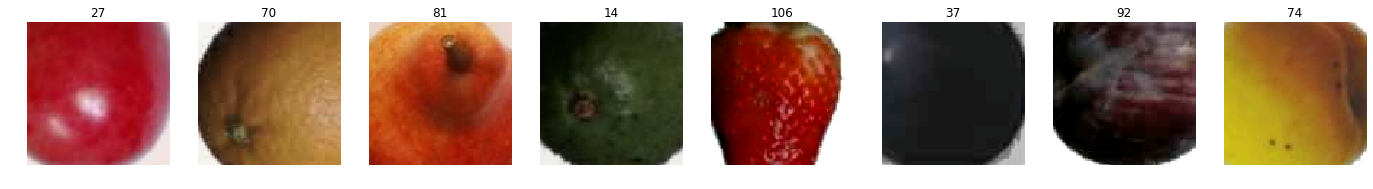

In [94]:
data_container.train.show()

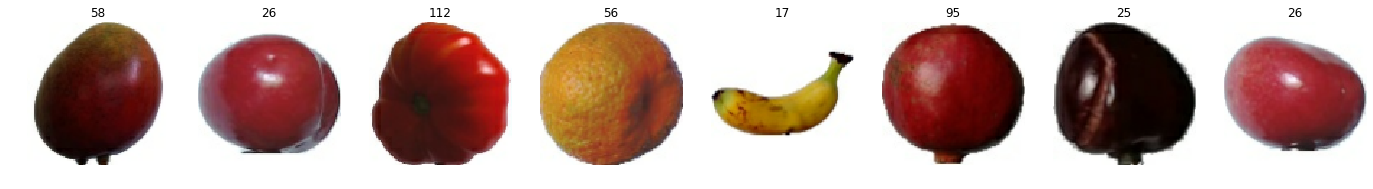

In [95]:
data_container.validation.show()

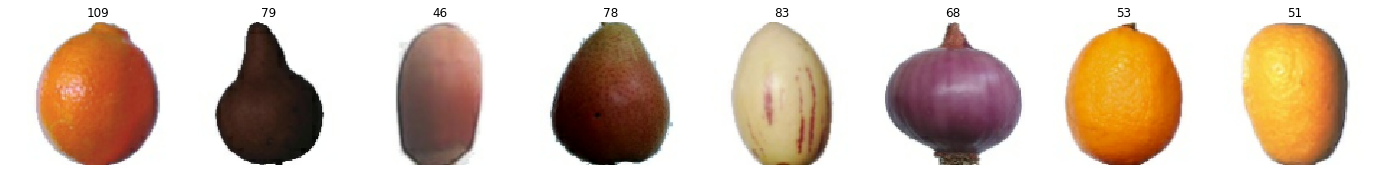

In [96]:
data_container.test.show()

## 4. Building and training the Models

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f'{self.path}/logs'

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)

        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)

        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                     keras.metrics.sparse_categorical_accuracy,
                     sparse_top_2_categorical_accuracy,
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
    
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)

    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })

    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)

    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, ros=2):
        print(mode)
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.prd) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plst.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{ro.pred_probs:.4f}"
            )

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()



In [0]:
def train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print('-'.center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [0]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=False,
)

In [100]:
train_learner(learner, epochs=(1, 1, 1))

Train for 927 steps, validate for 835 steps
927/927 [==============================] - 175s 188ms/step - loss: 4.5262 - sparse_categorical_accuracy: 0.1201 - sparse_top_2_categorical_accuracy: 0.1776 - val_loss: 2.6470 - val_sparse_categorical_accuracy: 0.3698 - val_sparse_top_2_categorical_accuracy: 0.4910
Train for 927 steps, validate for 835 steps
927/927 [==============================] - 463s 499ms/step - loss: 3.2671 - sparse_categorical_accuracy: 0.2801 - sparse_top_2_categorical_accuracy: 0.3954 - val_loss: 1.6791 - val_sparse_categorical_accuracy: 0.5509 - val_sparse_top_2_categorical_accuracy: 0.6948
Train for 927 steps, validate for 835 steps
927/927 [==============================] - 458s 494ms/step - loss: 1.5104 - sparse_categorical_accuracy: 0.6069 - sparse_top_2_categorical_accuracy: 0.7437 - val_loss: 0.9378 - val_sparse_categorical_accuracy: 0.7448 - val_sparse_top_2_categorical_accuracy: 0.8807
-------------------------------------------------------------------------

We train once again, but using already pretrained model/weights from previous steps!

In [0]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=True,
)

In [102]:
train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4))

Train for 927 steps, validate for 835 steps
927/927 [==============================] - 201s 217ms/step - loss: 1.0108 - sparse_categorical_accuracy: 0.7310 - sparse_top_2_categorical_accuracy: 0.8552 - val_loss: 0.8148 - val_sparse_categorical_accuracy: 0.7789 - val_sparse_top_2_categorical_accuracy: 0.8892
Train for 927 steps, validate for 835 steps
927/927 [==============================] - 459s 495ms/step - loss: 0.8503 - sparse_categorical_accuracy: 0.7714 - sparse_top_2_categorical_accuracy: 0.8865 - val_loss: 0.5334 - val_sparse_categorical_accuracy: 0.8749 - val_sparse_top_2_categorical_accuracy: 0.9551
Train for 927 steps, validate for 835 steps
927/927 [==============================] - 451s 487ms/step - loss: 0.6193 - sparse_categorical_accuracy: 0.8395 - sparse_top_2_categorical_accuracy: 0.9252 - val_loss: 0.4988 - val_sparse_categorical_accuracy: 0.8738 - val_sparse_top_2_categorical_accuracy: 0.9536
-------------------------------------------------------------------------

In [0]:
# train_learner(learner, epochs=(5, 5, 5), lrs=(1e-3, 3e-4, 3e-4))

In [0]:
# train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4))

Exploring results of trained model with "efficientnetb0_v1" architecture

In [103]:
learner.show_predictions(correct=True, ascending=True)

validation


IndexError: ignored

We will check different architectures for training

In [0]:
def train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print("-".center(90, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))


In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [0]:
learners = []

for path, base_model in [
    LearnerParams('resnet50_v1', keras.applications.ResNet50),
    LearnerParams("mobilenetv2_v1", keras.applications.MobileNetV2),
    LearnerParams('xception_v1', keras.applications.Xception),
    LearnerParams("efficientnetb4_v1", efn.EfficientNetB4),
]:

    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=IMG_DIMS,
        dropout=0.5,
        l1=1e-5,
        l2=1e-4,
        override=True,
        load=True,
    )
    train_learner(learner)
    learners.append(learner.history.history.copy())
    del learner

## Summary:




the best result with efficientnetB0 - 68% acc